# Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import numpy as np
from tqdm import tqdm
import dask.dataframe as dd

mpl.style.use('default')
#%matplotlib notebook
%matplotlib inline
sns.set()

# Tensorflow backend initialization

In [2]:
"""
Setup multi GPU usage

Example usage:
model = Sequential()
...
multi_model = multi_gpu_model(model, gpus=num_gpu)
multi_model.fit()

About memory usage:
https://stackoverflow.com/questions/34199233/how-to-prevent-tensorflow-from-allocating-the-totality-of-a-gpu-memory
"""
import tensorflow as tf
from keras.utils.training_utils import multi_gpu_model
from tensorflow.python.client import device_lib

# IMPORTANT: Tells tf to not occupy a specific amount of memory
from keras.backend.tensorflow_backend import set_session  
config = tf.ConfigProto()  
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU  
sess = tf.Session(config=config)  
set_session(sess)  # set this TensorFlow session as the default session for Keras.


# getting the number of GPUs 
def get_available_gpus():
   local_device_protos = device_lib.list_local_devices()
   return [x.name for x in local_device_protos if x.device_type    == 'GPU']
num_gpu = len(get_available_gpus())
print('Amount of GPUs available: %s' % num_gpu)

/opt/jupyterhub/anaconda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
Using TensorFlow backend.


Amount of GPUs available: 4


# Function definitions

In [3]:
def create_corr_matrix(df, dwelling_id, annot):
    """
    Pearson correlation coefficient matrix. 
    The Pearson correlation coefficient is a measure of the linear correlation between two variables.
    """
    plt.clf()
    
    corr = df.corr()
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True

    if annot:
        fig, ax = plt.subplots(figsize=(25,25))
    else:
        fig, ax = plt.subplots()

    fig = sns.heatmap(corr, mask=mask, square=False, cmap='RdYlGn', annot=annot, ax=ax, 
                cbar_kws={'label':'Pearson correlation coefficient [-]'})

    fig.set_title('Correlation matrix of dwelling ID: '+dwelling_id)
    fig.tick_params(axis='x', rotation=90)
    fig.tick_params(axis='y', rotation=0)

    fig = fig.get_figure()
    fig.tight_layout()
    fig.show()
    
    print('Saving heatmap')
    #fig.savefig('//datc//opschaler//EDA//Pearson_corr//' + dwelling_id + '.png', dpi=300)
    return fig


def reduce_memory(df):
    """
    Reduces memory footprint of the input dataframe.
    Changes float64 columns to float32 dtype.
    """
    columns = df.columns
    memory_before = df.memory_usage(deep=False).sum() / 2**30 # convert bytes to GB

    for column in tqdm(columns):
        if df[column].dtype == 'float64':
            df[column] = df[column].astype('float32')
        
    memory_after = df.memory_usage(deep=False).sum() / 2**30 # convert bytes to GB
    print('Memory uasge reduced from %.3f GB to %.3f GB' % (memory_before, memory_after))
    
    return df


def resample_df(df, sample_rate, combine_all_dwellings=False):
    """
    Resampled a (un)processed dataframe to the specified sample_rate.
    Input is a (un)processed df.
    Input df may also be multiple dwelling dfs combined.
    Sample rate must be a string. 
    For example '1H', '1D', '60s'.
    
    Combine all dwellings: resamples the df and ignores the fact that there are unique dwellings.
    
    TODO: add std to ePower, gasPower when combine_all_dwellings=False
    """
    df = df.copy()
    
    def resample_dwelling(df, sample_rate, dwelling_id):
        df = df.resample(sample_rate).mean() # resample to rest by mean
        df['dwelling'] = dwelling_id
        return df
        
                      
    resampled_dwellings = []
    
    if combine_all_dwellings: # Ignore dwelling_ids
        df = df.drop(['eMeter', 'eMeterReturn', 'eMeterLow', 'eMeterLowReturn', 'gasMeter'], axis=1) # Drop columns because they are meaningless when ignoring dwelling ids
        resampled_df = resample_dwelling(df, sample_rate, 'All dwellings')
        resampled_dwellings.append(resampled_df)
    else:
        dwellings = df['dwelling'].unique() # Get dwelling ids
        for dwelling_id in tqdm(dwellings):
            dwelling_df = df[df['dwelling'] == dwelling_id] # Get the data from only that dwelling_id
            resampled_dwelling = resample_dwelling(dwelling_df, sample_rate, dwelling_id)
            resampled_dwellings.append(resampled_dwelling)
    
    resampled_df = pd.concat(resampled_dwellings)
    
    return resampled_df

# Preparing dataframe for preprocessing

In [4]:
%%time
df = pd.read_csv('//datc//opschaler//combined_gas_smart_weather_dfs//processed//P01S01W8655_hour.csv', delimiter='\t', parse_dates=['datetime'])
df = df.set_index(['datetime'])
df = df.dropna()

# Get an hour dataframe
df = resample_df(df, 'D') # For some reason this makes df equal h, so it changes the df variable being read in at the start...
#df['year'] = df.index.year
#df['month'] = df.index.month
#df['day'] = df.index.day
#df['hour'] = df.index.hour #create column containing the hour
#df['dayofweek'] = df.index.dayofweek
#df['season'] = (df.index.month%12 + 3)//3 # Calculates the season (categorical)

#df = df.iloc[-7*5:]

100%|██████████| 1/1 [00:00<00:00, 157.74it/s]

CPU times: user 32.5 ms, sys: 4.63 ms, total: 37.2 ms
Wall time: 34.8 ms


In [5]:
df.head()

,eMeter,eMeterReturn,eMeterLow,eMeterLowReturn,ePower,ePowerReturn,gasMeter,DD,DR,FF,...,RG,SQ,T,T10,TD,U,VV,WW,gasPower,dwelling
datetime,,,,,,,,,,,,,,,,,,,,,
2017-04-24,780.522364,0.0,736.983000,0.0,450.653377,0.0,1592.778182,267.907575,151.272727,4.926667,...,0.350000,0.220361,10.819697,11.121212,6.662121,75.712122,29368.333455,29.696970,0.201372,P01S01W8655
2017-04-25,784.964250,0.0,738.217500,0.0,365.682568,0.0,1595.581708,285.680485,47.416667,5.478194,...,0.080208,4.004910,6.503472,6.373403,1.977500,72.906250,36118.680500,23.550000,0.150121,P01S01W8655
2017-04-26,792.118045,0.0,739.742318,0.0,376.575828,0.0,1601.333091,270.914473,42.545455,3.074758,...,0.112348,3.856208,6.132197,5.827121,2.092727,76.340910,34583.575909,12.346970,0.375732,P01S01W8655
2017-04-27,796.967000,0.0,744.674917,0.0,411.699121,0.0,1608.707583,233.521111,17.708333,2.968375,...,0.023264,2.682295,6.181319,5.922500,2.129722,76.137500,36665.555917,11.267361,0.213999,P01S01W8655
2017-04-28,800.575875,0.0,751.724250,0.0,511.259890,0.0,1614.828083,266.770347,58.366667,2.997917,...,0.156111,2.737647,7.958750,7.910486,4.364167,78.612500,33648.791625,18.394445,0.251663,P01S01W8655


## Get a proper hourly dataframe

Saving heatmap


/opt/jupyterhub/anaconda/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


<Figure size 576x396 with 0 Axes>

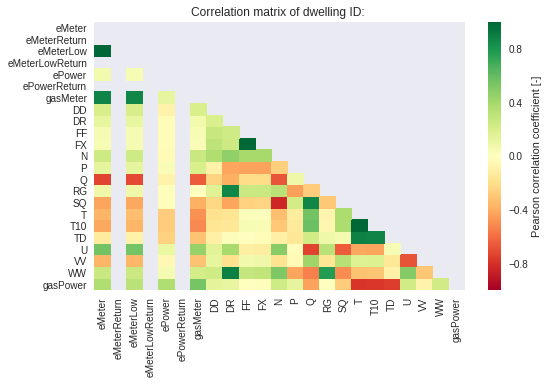

In [6]:
fig = create_corr_matrix(df, '', False)

## Select data we want

Len of data:  208


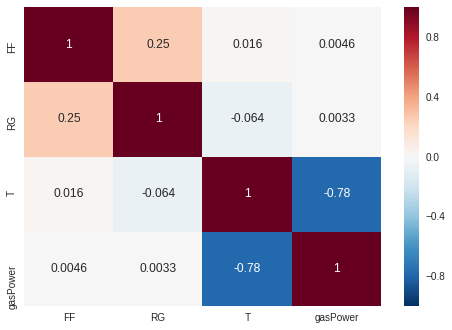

In [7]:
data = df
data = data.drop(['eMeter', 'eMeterReturn', 'eMeterLow', 'eMeterLowReturn', 'gasMeter', 'dwelling'], axis=1) # Not needed
data = data.drop(['WW', 'VV', 'P', 'DR', 'SQ', 'TD', 'T10', 'FX'], axis=1) # Drop weather columns which contain correlated information, keep only one type
#sns.heatmap(data.corr(), annot=True)

data = data.drop(['ePower', 'ePowerReturn'], axis=1) # Drop if want to predict gasPower

# Drop columns with that have a |corr| > 0.1 with T
data = data.drop(['U', 'N', 'Q', 'DD'], axis=1)


#data = data[data['T'] < 0] #filter data based on condition
#data = data.reset_index()
magnitude = 1
data['gasPower'] = data['gasPower']*10**magnitude
data = data.dropna()

sns.heatmap(data.corr(), annot=True)

print('Len of data: ', len(data))

# EDA

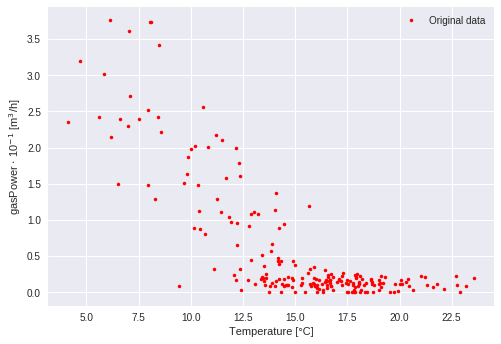

In [8]:
plt.plot(data['T'], data['gasPower'], '.', color='r', label='Original data')
plt.xlabel('Temperature [°C]')
plt.ylabel(r'gasPower $\cdot$ 10$^{-%s}$ [m$^3$/h]' % magnitude)
plt.legend()

In [9]:
#sns.pairplot(data)

# Preprocessing

In [10]:
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.preprocessing import StandardScaler

In [11]:
# Get the gasPower column
gp = data[['gasPower']]*10
#gp = data
print(gp.columns)
print(len(gp))

train_length = 0.3



gp_train = gp[:int(len(gp)*train_length)]
gp_test = gp[int(len(gp)*train_length):]

Index(['gasPower'], dtype='object')
208


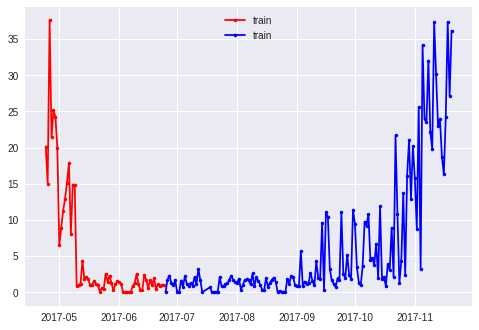

In [12]:
plt.plot(gp_train.index, gp_train['gasPower'], '.-', label='train', color='r')
plt.plot(gp_test.index, gp_test['gasPower'], '.-', label='train', color='b')
plt.legend()

In [13]:
gp_train = np.array(gp_train)
gp_test = np.array(gp_test)

gp_train

array([[20.13716282],
       [15.01210527],
       [37.57324159],
       [21.3999431 ],
       [25.16632053],
       [24.25925477],
       [19.94578005],
       [ 6.5419515 ],
       [ 8.84551988],
       [11.2670898 ],
       [12.94148742],
       [15.1418051 ],
       [17.8995767 ],
       [ 8.10038251],
       [14.88591983],
       [14.79187065],
       [ 0.80899324],
       [ 1.02945965],
       [ 1.15000404],
       [ 4.3665569 ],
       [ 1.76645911],
       [ 2.14996337],
       [ 1.78782147],
       [ 0.95825194],
       [ 1.06252033],
       [ 1.54164625],
       [ 1.10015875],
       [ 1.06252033],
       [ 0.        ],
       [ 0.63587536],
       [ 0.42521159],
       [ 2.54974365],
       [ 1.45467121],
       [ 2.27915445],
       [ 1.26241048],
       [ 0.26245117],
       [ 1.09558105],
       [ 1.49180095],
       [ 1.34989426],
       [ 1.14186604],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0

In [14]:
batch_size = 1
input_sequence_length = 7 #Length of the sequence used by the encoder
target_sequence_length = 7 # Length of the sequence predicted by the decoder
num_steps_to_predict = 7 # Length to use when testing the model


# Amount of epochs to do
steps_per_epoch = 200 # batch_size * steps_per_epoch = total number of training examples
n_folds = 2

array = np.array(gp)
array[:5]

array([[20.13716282],
       [15.01210527],
       [37.57324159],
       [21.3999431 ],
       [25.16632053]])

In [15]:
"""
Input is an array, for example (when data is a pd df):
array = data[['gasPower']]
array = np.array(array)
"""
array = array.copy()
    
n_columns = array.shape[1]
num_points = input_sequence_length + target_sequence_length
    
n_folds = array.shape[0] // num_points # For example with 208 / 14 = 14.85 then 208//14=14
#print('n_folds is %.1f so taking value %s ' % (gp.shape[0]/num_points, n_folds))
    
total_folds = n_folds // batch_size
print('total_folds', total_folds)
#print('total_batches is %.1f so taking value %s' % (n_folds/batch_size, total_batches))
    
    
signals = []
#print('signals initial shape: ', signals.shape)

for fold in range(n_folds): # slice the array in n_folds
    start = fold*num_points
    signal = array[start:start+num_points] # take values of the slices
    signals.append(signal) # append slice to the signals list


signals = np.asarray(signals) # list of arrays to one array
signals

total_folds 14


array([[[20.13716282],
        [15.01210527],
        [37.57324159],
        [21.3999431 ],
        [25.16632053],
        [24.25925477],
        [19.94578005],
        [ 6.5419515 ],
        [ 8.84551988],
        [11.2670898 ],
        [12.94148742],
        [15.1418051 ],
        [17.8995767 ],
        [ 8.10038251]],

       [[14.88591983],
        [14.79187065],
        [ 0.80899324],
        [ 1.02945965],
        [ 1.15000404],
        [ 4.3665569 ],
        [ 1.76645911],
        [ 2.14996337],
        [ 1.78782147],
        [ 0.95825194],
        [ 1.06252033],
        [ 1.54164625],
        [ 1.10015875],
        [ 1.06252033]],

       [[ 0.        ],
        [ 0.63587536],
        [ 0.42521159],
        [ 2.54974365],
        [ 1.45467121],
        [ 2.27915445],
        [ 1.26241048],
        [ 0.26245117],
        [ 1.09558105],
        [ 1.49180095],
        [ 1.34989426],
        [ 1.14186604],
        [ 0.        ],
        [ 0.        ]],

       [[ 0.        ],
     

In [16]:
#print('signals final shape: ', signals.shape)
    
"""
Split all signals into amount of total batches, generator should iterate over this and return each batch. 
i.e. iterate with i over (i, 3, 14, 1) if  size is (4, 2, 14, 1), from 0 to i=3.
"""

batch_len = signals.shape[0] // total_folds
print('batch_len: ', batch_len)

folds = []
for i in range(total_folds):
    start = i*batch_len
    stop = start + batch_len
    fold = signals[start:stop] # take the values of the slices
    folds.append(fold)

folds = np.asarray(folds)
    
print('We have got %s folds with %s batches of %s steps with %s columns.' % (folds.shape[0], folds.shape[1], folds.shape[2], folds.shape[3]))

batch_len:  1
We have got 14 folds with 1 batches of 14 steps with 1 columns.


In [17]:
fold = folds[0]
print('fold shape', fold.shape)
print(fold)

encoder_input = fold[:, :input_sequence_length, :]
decoder_output = fold[:, input_sequence_length:, :]
decoder_input = np.zeros((decoder_output.shape[0], decoder_output.shape[1], 1))

print(decoder_input)
decoder_output

fold shape (1, 14, 1)
[[[20.13716282]
  [15.01210527]
  [37.57324159]
  [21.3999431 ]
  [25.16632053]
  [24.25925477]
  [19.94578005]
  [ 6.5419515 ]
  [ 8.84551988]
  [11.2670898 ]
  [12.94148742]
  [15.1418051 ]
  [17.8995767 ]
  [ 8.10038251]]]
[[[0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]]]


array([[[ 6.5419515 ],
        [ 8.84551988],
        [11.2670898 ],
        [12.94148742],
        [15.1418051 ],
        [17.8995767 ],
        [ 8.10038251]]])

gp = np.arange(100)
gp = gp.reshape(100, 1)
gp.shape

In [18]:
def array_to_seq2seq_format(array, target_index, input_seq_len, output_seq_len, batch_size, n_epochs):
    """
    Input is an array, for example (when data is a pd df):
    array = data[['gasPower']]
    array = np.array(array)
    """
    array = array.copy()
    
    n_columns = array.shape[1]
    num_points = input_seq_len + output_seq_len
    
    n_folds = array.shape[0] // num_points # For example with 208 / 14 = 14.85 then 208//14=14
    #print('n_folds is %.1f so taking value %s ' % (gp.shape[0]/num_points, n_folds))
    
    total_folds = n_folds // batch_size
    print('total_folds', total_folds)
    #print('total_batches is %.1f so taking value %s' % (n_folds/batch_size, total_batches))
    
    
    signals = []
    #print('signals initial shape: ', signals.shape)

    for fold in range(n_folds): # slice the array in n_folds
        start = fold*num_points
        signal = array[start:start+num_points] # take values of the slices
        signals.append(signal) # append slice to the signals list

    signals = np.asarray(signals) # list of arrays to one array

    #print('signals final shape: ', signals.shape)
    
    """
    Split all signals into amount of total batches, generator should iterate over this and return each batch. 
    i.e. iterate with i over (i, 3, 14, 1) if  size is (4, 2, 14, 1), from 0 to i=3.
    """

    batch_len = signals.shape[0] // total_folds
    print('batch_len: ', batch_len)

    folds = []
    for i in range(total_folds):
        start = i*batch_len
        stop = start + batch_len
        fold = signals[start:stop] # take the values of the slices
        folds.append(fold)

    folds = np.asarray(folds)
    
    print('We have got %s folds with %s batches of %s steps with %s columns.' % (folds.shape[0], folds.shape[1], folds.shape[2], folds.shape[3]))
    
    for _ in range(n_epochs):
        for fold in folds:
            encoder_input = fold[:, :input_seq_len, :]
            decoder_output = fold[:, input_seq_len:, [target_index]]
            decoder_input = np.zeros((decoder_output.shape[0], decoder_output.shape[1], 1))
        
            yield [encoder_input, decoder_input], decoder_output
    
    

# Create model

# Hyperparameters and model configuration

In [19]:
import numpy as np
import keras
import matplotlib.pyplot as plt
import tensorflow as tf

keras.backend.clear_session()

layers = [35, 35] # Number of hidden neuros in each layer of the encoder and decoder

learning_rate = 0.01
decay = 0 # Learning rate decay
optimiser = keras.optimizers.Adam(lr=learning_rate, decay=decay) # Other possible optimiser "sgd" (Stochastic Gradient Descent)

num_input_features = 1 # The dimensionality of the input at each time step. In this case a 1D signal.
num_output_features = 1 # The dimensionality of the output at each time step. In this case a 1D signal.
# There is no reason for the input sequence to be of same dimension as the ouput sequence.
# For instance, using 3 input signals: consumer confidence, inflation and house prices to predict the future house prices.

loss = "mse" # Other loss functions are possible, see Keras documentation.

# Regularisation isn't really needed for this application
lambda_regulariser = 0.000001 # Will not be used if regulariser is None
regulariser = None # Possible regulariser: keras.regularizers.l2(lambda_regulariser)

###########################################


batch_size = 1
input_sequence_length = 7 #Length of the sequence used by the encoder
target_sequence_length = 7 # Length of the sequence predicted by the decoder
num_steps_to_predict = 7 # Length to use when testing the model

target_index = 0

# Amount of epochs to do
steps_per_epoch = 1000 # batch_size * steps_per_epoch = total number of training examples
n_folds = 1
###########################################





train_gen = array_to_seq2seq_format(gp_train, target_index, input_sequence_length, target_sequence_length, batch_size, n_folds)
_ = next(train_gen)

test_gen = array_to_seq2seq_format(gp_test, target_index, input_sequence_length, target_sequence_length, batch_size, n_folds)
_ = next(test_gen)

total_folds 4
batch_len:  1
We have got 4 folds with 1 batches of 14 steps with 1 columns.
total_folds 10
batch_len:  1
We have got 10 folds with 1 batches of 14 steps with 1 columns.


## Create encoder

In [20]:
# Define an input sequence.
encoder_inputs = keras.layers.Input(shape=(None, num_input_features))

# Create a list of RNN Cells, these are then concatenated into a single layer
# with the RNN layer.
encoder_cells = []
for hidden_neurons in layers:
    encoder_cells.append(keras.layers.GRUCell(hidden_neurons,
                                              kernel_regularizer=regulariser,
                                              recurrent_regularizer=regulariser,
                                              bias_regularizer=regulariser))

encoder = keras.layers.RNN(encoder_cells, return_state=True)

encoder_outputs_and_states = encoder(encoder_inputs)

# Discard encoder outputs and only keep the states.
# The outputs are of no interest to us, the encoder's
# job is to create a state describing the input sequence.
encoder_states = encoder_outputs_and_states[1:]

## Create decoder

In [21]:
# The decoder input will be set to zero (see random_sine function of the utils module).
# Do not worry about the input size being 1, I will explain that in the next cell.
decoder_inputs = keras.layers.Input(shape=(None, 1))

decoder_cells = []
for hidden_neurons in layers:
    decoder_cells.append(keras.layers.GRUCell(hidden_neurons,
                                              kernel_regularizer=regulariser,
                                              recurrent_regularizer=regulariser,
                                              bias_regularizer=regulariser))

decoder = keras.layers.RNN(decoder_cells, return_sequences=True, return_state=True)

# Set the initial state of the decoder to be the ouput state of the encoder.
# This is the fundamental part of the encoder-decoder.
decoder_outputs_and_states = decoder(decoder_inputs, initial_state=encoder_states)

# Only select the output of the decoder (not the states)
decoder_outputs = decoder_outputs_and_states[0]

# Apply a dense layer with linear activation to set output to correct dimension
# and scale (tanh is default activation for GRU in Keras, our output sine function can be larger then 1)
decoder_dense = keras.layers.Dense(num_output_features,
                                   activation='linear',
                                   kernel_regularizer=regulariser,
                                   bias_regularizer=regulariser)

decoder_outputs = decoder_dense(decoder_outputs)

## Create model and compile

In [22]:
# Create a model using the functional API provided by Keras.
# The functional API is great, it gives an amazing amount of freedom in architecture of your NN.
# A read worth your time: https://keras.io/getting-started/functional-api-guide/ 
model = keras.models.Model(inputs=[encoder_inputs, decoder_inputs], outputs=decoder_outputs)

#model = multi_gpu_model(model, gpus=num_gpu)

model.compile(optimizer='adam', loss='mse', metrics=['mse'])


## Fit model

In [23]:
l = 50
x1 = np.arange(l)
x2 = np.arange(l, l*2)

encoder_input_train = (np.sin(x1)*0.1*x1).reshape(1, l, 1)
decoder_input_train = np.zeros(l).reshape(1, l, 1)
decoder_output_train = (np.sin(x2)*0.1*x2).reshape(1, l, 1)

In [24]:
gp = np.array(gp)
print(len(gp))

l= len(gp) - num_steps_to_predict
gp_train = gp[:l]
gp_test = gp[l:]


print(gp_train[:3])

print(gp_test[:3])

208
[[20.13716282]
 [15.01210527]
 [37.57324159]]
[[23.99139413]
 [18.72507729]
 [16.31673165]]


In [25]:
encoder_input_train = gp_train.reshape(1, len(gp_train), 1)
decoder_input_train = gp_train.reshape(1, len(gp_train), 1)
decoder_output_train = gp_train.reshape(1, len(gp_train), 1)

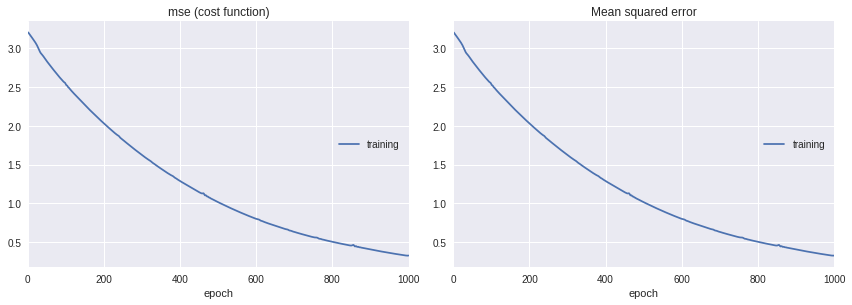

1/1 [==============================] - 1s 729ms/step - loss: 0.3254 - mean_squared_error: 0.3254


In [43]:
from livelossplot import PlotLossesKeras

model.fit([encoder_input_train, decoder_input_train], decoder_output_train, epochs=1000, verbose=1, callbacks=[PlotLossesKeras()])

train_gen = array_to_seq2seq_format(gp_train, target_index, input_sequence_length, target_sequence_length, batch_size, steps_per_epoch)
test_gen = array_to_seq2seq_format(gp_test, target_index, input_sequence_length, target_sequence_length, batch_size, steps_per_epoch)

#model.fit_generator(generator=train_gen, steps_per_epoch=steps_per_epoch, epochs=n_folds, validation_data=test_gen, validation_steps=steps_per_epoch)
model.fit_generator(generator=train_gen, steps_per_epoch=steps_per_epoch, epochs=n_folds)

# Create 'prediction' models

In [44]:
def plot_prediction(x, y_true, y_pred):
    """Plots the predictions.
    
    Arguments
    ---------
    x: Input sequence of shape (input_sequence_length,
        dimension_of_signal)
    y_true: True output sequence of shape (input_sequence_length,
        dimension_of_signal)
    y_pred: Predicted output sequence (input_sequence_length,
        dimension_of_signal)
    """

    plt.figure(figsize=(12, 3))

    output_dim = x.shape[-1]
    for j in range(output_dim):
        past = x[:, j] 
        true = y_true[:, j]
        pred = y_pred[:, j]

        label1 = "Seen (past) values" if j==0 else "_nolegend_"
        label2 = "True future values" if j==0 else "_nolegend_"
        label3 = "Predictions" if j==0 else "_nolegend_"

        plt.plot(range(len(past)), past, "o--b",
                 label=label1)
        plt.plot(range(len(past),
                 len(true)+len(past)), true, "x--b", label=label2)
        plt.plot(range(len(past), len(pred)+len(past)), pred, "o--y",
                 label=label3)
    plt.legend(loc='best')
    plt.title("Predictions v.s. true values")
    plt.show()

In [45]:
encoder_predict_model = keras.models.Model(encoder_inputs,
                                           encoder_states)

decoder_states_inputs = []

# Read layers backwards to fit the format of initial_state
# For some reason, the states of the model are order backwards (state of the first layer at the end of the list)
# If instead of a GRU you were using an LSTM Cell, you would have to append two Input tensors since the LSTM has 2 states.
for hidden_neurons in layers[::-1]:
    # One state for GRU
    decoder_states_inputs.append(keras.layers.Input(shape=(hidden_neurons,)))

decoder_outputs_and_states = decoder(
    decoder_inputs, initial_state=decoder_states_inputs)

decoder_outputs = decoder_outputs_and_states[0]
decoder_states = decoder_outputs_and_states[1:]

decoder_outputs = decoder_dense(decoder_outputs)

decoder_predict_model = keras.models.Model(
        [decoder_inputs] + decoder_states_inputs,
        [decoder_outputs] + decoder_states)

In [46]:
# Let's define a small function that predicts based on the trained encoder and decoder models

def predict(x, encoder_predict_model, decoder_predict_model, num_steps_to_predict):
    """Predict time series with encoder-decoder.
    
    Uses the encoder and decoder models previously trained to predict the next
    num_steps_to_predict values of the time series.
    
    Arguments
    ---------
    x: input time series of shape (batch_size, input_sequence_length, input_dimension).
    encoder_predict_model: The Keras encoder model.
    decoder_predict_model: The Keras decoder model.
    num_steps_to_predict: The number of steps in the future to predict
    
    Returns
    -------
    y_predicted: output time series for shape (batch_size, target_sequence_length,
        ouput_dimension)
    """
    y_predicted = []

    # Encode the values as a state vector
    states = encoder_predict_model.predict(x)

    # The states must be a list
    if not isinstance(states, list):
        states = [states]

    # Generate first value of the decoder input sequence
    decoder_input = np.zeros((x.shape[0], 1, 1))


    for _ in range(num_steps_to_predict):
        outputs_and_states = decoder_predict_model.predict(
        [decoder_input] + states, batch_size=batch_size)
        output = outputs_and_states[0]
        states = outputs_and_states[1:]

        # add predicted value
        y_predicted.append(output)

    return np.concatenate(y_predicted, axis=1)
    

# The aim of this tutorial isn't to present how to evaluate the model or investigate the training.
# We could plot evaluation metrics such as RMSE over time, compare train and test batches for overfitting,
# produce validation and learning curves to analyse the effect of the number of epochs or training examples,
# have fun playing with tensorboard etc... We would need at least a whole other post for this.
# However, let's at least make sure that our model can predict correctly...
# Ask the generator to produce a batch of samples, don't forget to set the seed to something other than what was
# used for training or you will be testing on train data.
# The next function asks the generator to produce it's first batch.

test_gen = array_to_seq2seq_format(gp_test, target_index, input_sequence_length, target_sequence_length, batch_size, steps_per_epoch)

(x_test, _), y_test = next(test_gen)




l = 50
x1 = np.arange(l)
x2 = np.arange(l, l*2)

encoder_input_test = (np.sin(x1)*0.35*x1).reshape(1, l, 1)
decoder_input_test = np.zeros(l).reshape(1, l, 1)
decoder_output_test = (np.sin(x2)*0.35*x2).reshape(1, l, 1)

In [47]:
encoder_input_test = gp_test.reshape(1, len(gp_test), 1)
decoder_input_test = np.zeros(len(gp_test)).reshape(1, len(gp_test), 1)
decoder_output_test = gp_test.reshape(1, len(gp_test), 1)

x_test = encoder_input_test
y_test = decoder_output_test

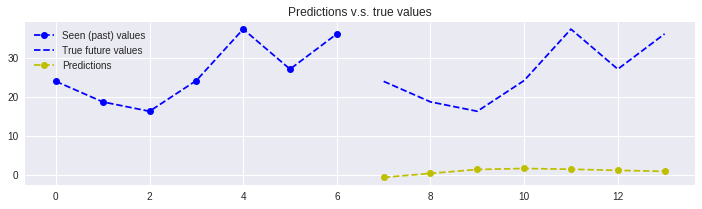

In [48]:
y_test_predicted = predict(x_test, encoder_predict_model, decoder_predict_model, num_steps_to_predict)


#y_test_predicted = decoder_output_test

np.random.seed(42)
# Select 10 random examples to plot
indices = np.random.choice(range(x_test.shape[0]), replace=False, size=batch_size)


for index in indices:
    plot_prediction(x_test[index, :, :], y_test[index, :, :], y_test_predicted[index, :, :])
    
# The model seems to struggle on very low wave signals. But that makes sense, the model doesn't see enough of the signal
# to make a good estimation of the frequency components.